## 1. 데이터 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [2]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

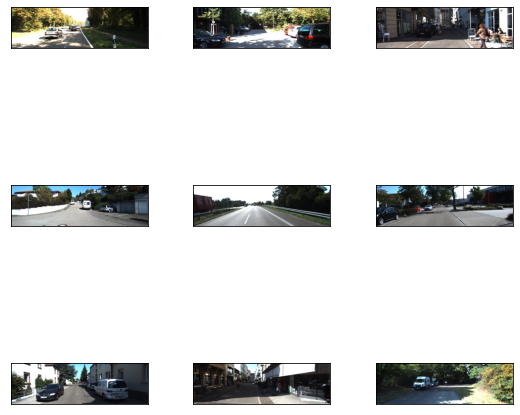

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

In [5]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.25], dtype=float32)>, 'bbox': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.45018667, 0.36198068, 0.50861335, 0.42161837]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.36, 1.68, 4.49]], dtype=float32)>, 'location': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-8.07,  2.13, 47.23]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, 'rotation_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.08], dtype=float32)>, 'truncated': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, 'type': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>}


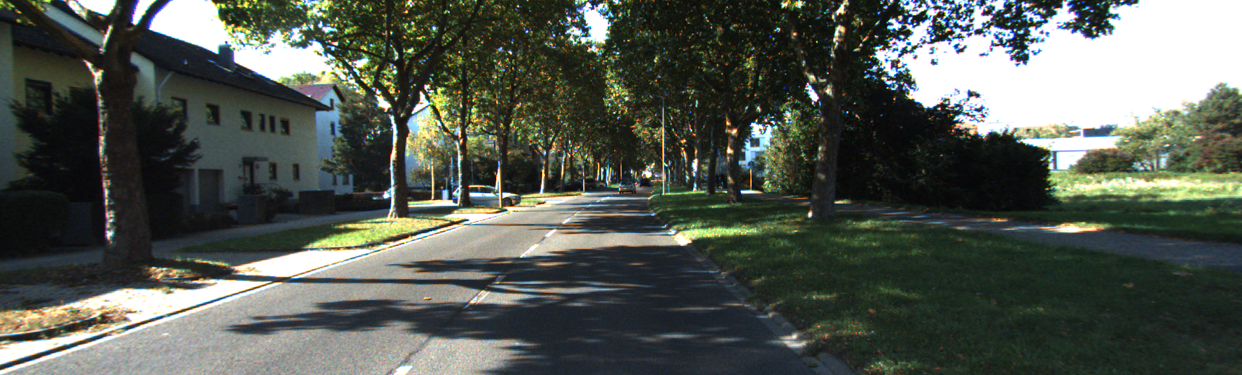

In [6]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

## 2. 바운딩박스

[[449.58    206.18    523.65    184.26999]]
[449.58    206.18    523.65    184.26999]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7FA5687C60D0>


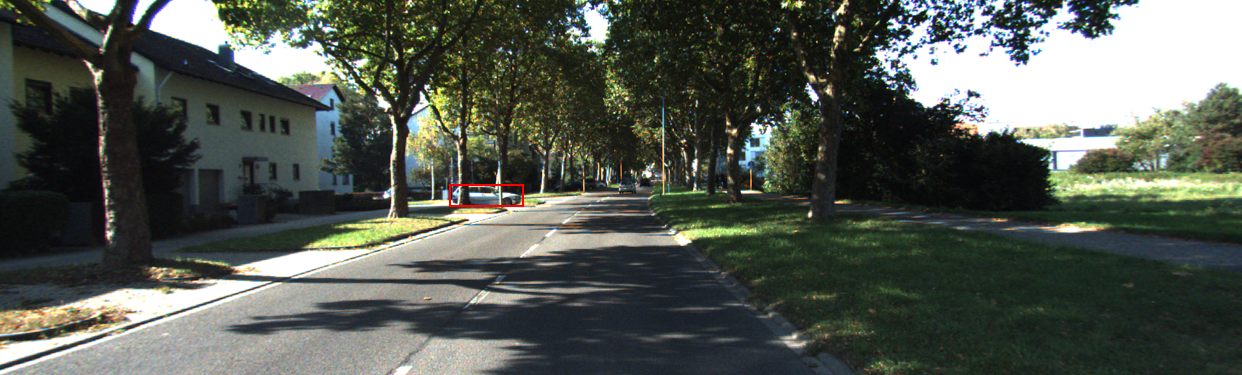

In [7]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    width, height = img.size
    x_min = object_bbox[:, 1] * width
    x_max = object_bbox[:, 3] * width
    y_min = height - object_bbox[:, 0] * height
    y_max = height - object_bbox[:, 2] * height
    
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    print(rects)
    
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 3. 데이터 포맷 변경

### 클래스 및 바운딩 박스 정보 추출

In [9]:
import os

data_dir = os.getenv('HOME') + '/project/aiffel/g/g3/data'
img_dir = os.getenv('HOME') + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

def parse_dataset(dataset, img_dir='kitti_images', total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    
    type_class_map = {
        0: 'car',
        1: 'car',
        2: 'car',
        3: 'person',
        4: 'person',
        5: 'person'
    }
    df = pd.DataFrame(columns=['img_path', 'x1', 'y1', 'x2', 'y2', 'class_name'])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        x_min = object_bbox[:, 1] * width
        x_max = object_bbox[:, 3] * width
        y_min = height - object_bbox[:, 2] * height
        y_max = height - object_bbox[:, 0] * height
        
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                'img_path': img_path,
                'x1': _rect[0],
                'y1': _rect[1],
                'x2': _rect[2],
                'y2': _rect[3],
                'class_name': type_class_map[_type]
            }, ignore_index=True)
            break
        
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)


100%|██████████| 6347/6347 [11:20<00:00,  9.32it/s]


In [12]:
test_csv_path = os.getenv('HOME') + '/project/aiffel/g/g3/data/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:17<00:00,  9.12it/s]


### 클래스 맵핑

In [10]:
class_txt_path = os.getenv('HOME') + '/project/aiffel/g/g3/data/classes.txt'

def save_class_format(path='./classes.txt'):
    class_type_map = {
        'car': 0,
        'person': 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k}, {v}\n")
    
save_class_format(class_txt_path)


## 4. Keras-Retinanet

In [12]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
# python ~/project/aiffel/g/g3/keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv ~/project/aiffel/g/g3/data/kitti_train.csv ~/project/aiffel/g/g3/data/classes.txt

In [13]:
# python ~/project/aiffel/g/g3/keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_50.h5 ./snapshots/resnet50_csv_50_infer.h5

## 5. 시각화

In [14]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import keras

from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

model_path = os.path.join('.', 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[593.0923  178.14488 625.7978  206.99196]
[191.61359 134.56181 346.95505 231.30269]


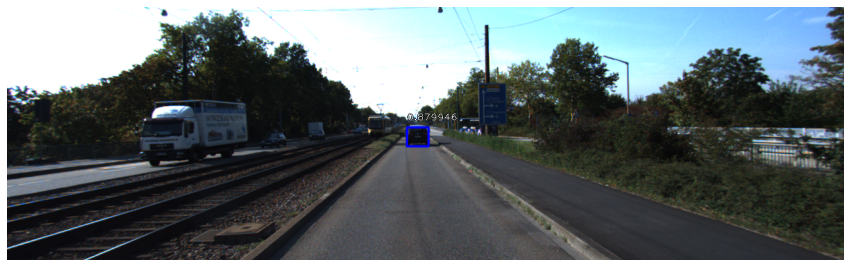

In [17]:
img_path = os.getenv('HOME') + '/project/aiffel/g/g3/test_set/go_1.png'

def inference_on_image(model,
                      img_path="./test_set/go_1.png",
                      visualize=True):
    image =read_image_bgr(img_path)
    
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0: (0, 0, 255),
        1: (255, 0, 0)
    }
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    boxes /= scale
    
    if visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])
            
            caption = "{:3f}".format(score)
            draw_caption(draw, b, caption)
        
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()

inference_on_image(model, img_path=img_path)

[770.4362  150.21735 839.2324  316.0842 ]
[768.89685 148.64087 838.82904 311.72336]


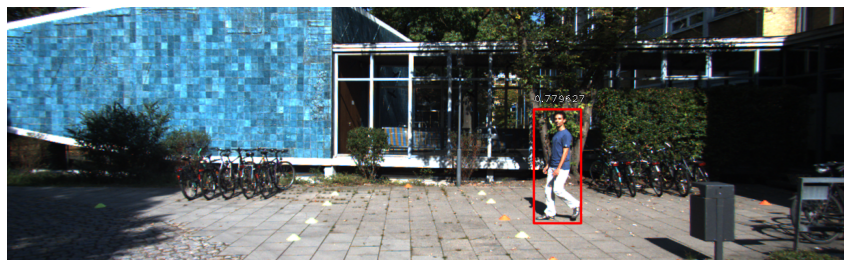

In [20]:
img_path = 'test_set/stop_1.png'

inference_on_image(model, img_path=img_path)

예시 이미지의 경우, 차는 파란색 박스로 사람은 빨간색 박스로 잘 검출했지만, 첫번째 사진에서 왼편의 트럭을 검출하지 못했다.

## 6. 자율주행 시스템

In [28]:
img_path = 'test_set/stop_2.png'

def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)
    
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0: (0, 0, 255),
        1: (255, 0, 0)
    }
    
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    boxes /= scale
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        
        if label == 1:
            return "Stop"
        elif label == 0:
            width = box[2] - box[0]
            height = box[3] - box[1]
            
            if width > 300 or height > 300:
                return 'Stop'
            else:
                return 'Go'
    

print(self_drive_assist(img_path))
            
            

Stop


In [29]:
print(self_drive_assist('test_set/go_2.png'))

Go


In [30]:
print(self_drive_assist('test_set/go_1.png'))

Go


### 평가

In [31]:
def test_system(func):
    work_dir = os.getenv('HOME') + '/project/aiffel/g/g3'
    score = 0
    test_set = [
               ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"), 
    ]
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

100점입니다.


### Report
- 자율주행 시스템에 대해 경험해볼 수 있는 좋은 경험이었다.
- 이미 있는 모델을 가져다 쓸 수 밖에 없었지만 언젠가 좋은 모델을 만들어 자율주행 시스템을 구현해보고 싶다.